In [ ]:
import os
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras import applications
from keras.applications import vgg16
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras_preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical
from keras_preprocessing import image
from keras_preprocessing.image import img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
EPOCHS = 35
INIT_LR = 1e-3
DECAY = 1e-6
BS = 64
default_image_size = tuple((128, 128))
image_size = 0
directory_root = '/content/drive/MyDrive/PlantVillage'
width=128
height=128
depth=3

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else:
            return np.array([])
        
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
image_list, label_list = [], []

In [ ]:
try:
    print("[INFO] Loading images ....")
    root_dir = listdir(directory_root)
    for plant_folder in root_dir:
        print(f"[INFO] Processing {plant_folder} ....")
        plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}")
        
        for image_var in plant_disease_image_list[:400]:
            image_directory = f"{directory_root}/{plant_folder}/{image_var}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_folder)
        
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ....
[INFO] Processing Tomato_healthy ....
[INFO] Processing Potato___healthy ....
[INFO] Processing Tomato_Septoria_leaf_spot ....
[INFO] Processing Tomato_Leaf_Mold ....
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ....
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ....
[INFO] Processing Potato___Late_blight ....
[INFO] Processing Potato___Early_blight ....
[INFO] Processing Tomato_Early_blight ....
[INFO] Processing Tomato__Target_Spot ....
[INFO] Processing Pepper__bell___Bacterial_spot ....
[INFO] Processing Pepper__bell___healthy ....
[INFO] Processing Tomato_Late_blight ....
[INFO] Processing Tomato_Bacterial_spot ....
[INFO] Processing Tomato__Tomato_mosaic_virus ....


In [ ]:
image_size = len(image_list)

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [ ]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [ ]:
np_image_list = np.array(image_list, dtype = np.float16)/ 225.0

In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Spliting data to train, test


In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2, horizontal_flip=True,
    fill_mode="nearest")

In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 42, 42, 64)        0

In [ ]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [ ]:
print("[INFO] training network...")

history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

[INFO] training network...
Epoch 1/35
71/71 [==============================] - 28s 251ms/step - loss: 0.7880 - accuracy: 0.2077 - val_loss: 0.5284 - val_accuracy: 0.0891
Epoch 2/35
71/71 [==============================] - 17s 233ms/step - loss: 0.2265 - accuracy: 0.4852 - val_loss: 0.4241 - val_accuracy: 0.0707
Epoch 3/35
71/71 [==============================] - 17s 232ms/step - loss: 0.1277 - accuracy: 0.6676 - val_loss: 0.4019 - val_accuracy: 0.1362
Epoch 4/35
71/71 [==============================] - 17s 234ms/step - loss: 0.0983 - accuracy: 0.7542 - val_loss: 0.6034 - val_accuracy: 0.0681
Epoch 5/35
71/71 [==============================] - 16s 232ms/step - loss: 0.0843 - accuracy: 0.8040 - val_loss: 1.6450 - val_accuracy: 0.1013
Epoch 6/35
71/71 [==============================] - 17s 232ms/step - loss: 0.0717 - accuracy: 0.8346 - val_loss: 0.5955 - val_accuracy: 0.1546
Epoch 7/35
71/71 [==============================] - 17s 234ms/step - loss: 0.0694 - accuracy: 0.8347 - val_loss: 1.

In [ ]:
def Res_Plot_Test_Save(name):
    print("[INFO] Plotting model accuracy and Loss")
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    #Train and validation accuracy
    plt.plot(epochs, acc, 'b', label='Training accurarcy')
    plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
    plt.title('Training and Validation accurarcy')
    plt.legend()

    plt.figure()
    #Train and validation loss
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()
    
    print("[INFO] Calculating model accuracy")
    scores = model.evaluate(x_test, y_test)
    print(f"Test Accuracy: {scores[1]*100}")
    
    print("[INFO] Saving model")
    model.save(name)
    

[INFO] Plotting model accuracy and Loss


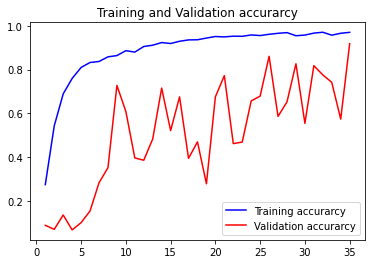

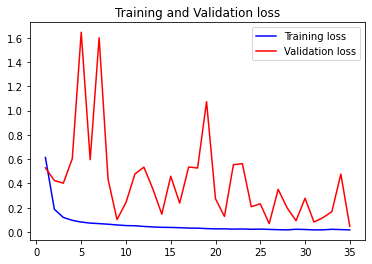

[INFO] Calculating model accuracy
36/36 [==============================] - 0s 9ms/step - loss: 0.0463 - accuracy: 0.9179
Test Accuracy: 91.79039597511292
[INFO] Saving model


In [ ]:
Res_Plot_Test_Save('5layer_CNN_Algorithm.h5')

In [ ]:
# Get the InceptionV3 model so we can do transfer learning
base_inception = InceptionV3(weights='imagenet', include_top=False, 
                             input_shape=(128, 128, 3))

In [ ]:
# Add a global spatial average pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model = Model(inputs=base_inception.input, outputs=predictions)

In [ ]:
# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False

In [ ]:
# Compile 
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"]) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 63, 63, 32)   96          conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 63, 63, 32)   0           batch_normalization_6[0][0]      
______________________________________________________________________________________________

In [ ]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/35
71/71 [==============================] - 26s 292ms/step - loss: 0.2843 - accuracy: 0.3017 - val_loss: 0.1237 - val_accuracy: 0.6463
Epoch 2/35
71/71 [==============================] - 17s 244ms/step - loss: 0.1264 - accuracy: 0.6348 - val_loss: 0.1079 - val_accuracy: 0.6943
Epoch 3/35
71/71 [==============================] - 17s 241ms/step - loss: 0.1087 - accuracy: 0.6845 - val_loss: 0.0981 - val_accuracy: 0.7179
Epoch 4/35
71/71 [==============================] - 17s 244ms/step - loss: 0.1021 - accuracy: 0.7009 - val_loss: 0.0927 - val_accuracy: 0.7231
Epoch 5/35
71/71 [==============================] - 17s 243ms/step - loss: 0.0943 - accuracy: 0.7273 - val_loss: 0.0965 - val_accuracy: 0.7214
Epoch 6/35
71/71 [==============================] - 17s 243ms/step - loss: 0.0907 - accuracy: 0.7345 - val_loss: 0.0863 - val_accuracy: 0.7354
Epoch 7/35
71/71 [==============================] - 17s 242ms/step - loss: 0.0886 - accuracy: 0.7350 - val_loss: 0.0793 - val_accuracy: 0.7677

[INFO] Plotting model accuracy and Loss


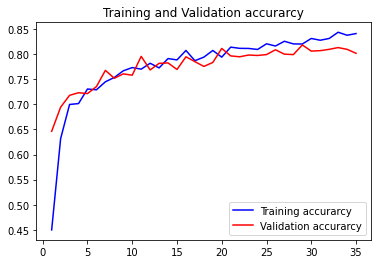

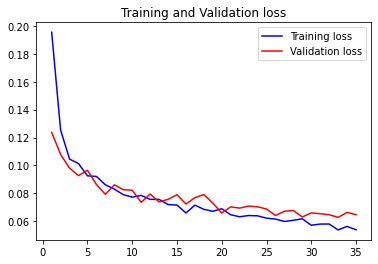

[INFO] Calculating model accuracy
36/36 [==============================] - 1s 29ms/step - loss: 0.0647 - accuracy: 0.8017
Test Accuracy: 80.17467260360718
[INFO] Saving model


In [ ]:
Res_Plot_Test_Save('Inception_ModelV3_(Imagenet_Weights).h5')

In [ ]:
# Get the Resnet model so we can do transfer learning
base_model = applications.resnet50.ResNet50(weights= 'imagenet', include_top=False, input_shape= (128,128,3))
                             
# Add a global spatial average pooling layer
out = base_model.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model = Model(inputs=base_model.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"]) 
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/35
71/71 [==============================] - 33s 365ms/step - loss: 0.1784 - accuracy: 0.5650 - val_loss: 139.3927 - val_accuracy: 0.0620
Epoch 2/35
71/71 [==============================] - 23s 319ms/step - loss: 0.0552 - accuracy: 0.8505 - val_loss: 1.3998 - val_accuracy: 0.0681
Epoch 3/35
71/71 [==============================] - 23s 320ms/step - loss: 0.0379 - accuracy: 0.8956 - val_loss: 1.1407 - val_accuracy: 0.0707
Epoch 4/35
71/71 [==============================] - 23s 320ms/step - loss: 0.0363 - accuracy: 0.9053 - val_loss: 0.5854 - val_accuracy: 0.0672
Epoch 5/35
71/71 [==============================] - 23s 318ms/step - loss: 0.0304 - accuracy: 0.9184 - val_loss: 0.7441 - val_accuracy: 0.0707
Epoch 6/35
71/71 [==============================] - 23s 320ms/step - loss: 0.0262 - accuracy: 0.9310 - val_loss: 1.5432 - val_accuracy: 0.0707
Epoch 7/35
71/71 [==============================] - 23s 320ms/step - loss: 0.0241 - accuracy: 0.9429 - val_loss: 0.7466 - val_accuracy: 0.07

[INFO] Plotting model accuracy and Loss


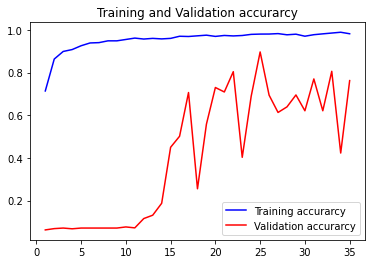

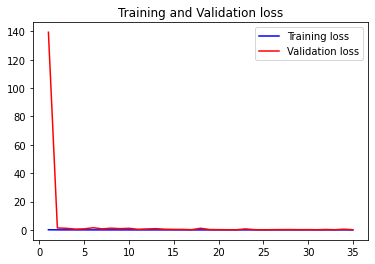

[INFO] Calculating model accuracy
36/36 [==============================] - 1s 39ms/step - loss: 0.1297 - accuracy: 0.7624
Test Accuracy: 76.24453902244568
[INFO] Saving model


In [ ]:
Res_Plot_Test_Save('Resnet_With_Imagenet_Weingts.h5')

In [ ]:
# Get the Resnet model so we can do transfer learning
vgg = vgg16.VGG16(weights= None, include_top=False, input_shape= (128,128,50))
                             
# Add a global spatial average pooling layer
out = base_model.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model = Model(inputs=base_model.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"]) 
model.summary()


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/applications/imagenet_utils.py:333: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 50 input channels.
  str(input_shape[-1]) + ' input channels.')


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/35
71/71 [==============================] - 29s 334ms/step - loss: 0.1165 - accuracy: 0.8262 - val_loss: 0.2535 - val_accuracy: 0.6882
Epoch 2/35
71/71 [==============================] - 23s 321ms/step - loss: 0.0146 - accuracy: 0.9655 - val_loss: 0.0717 - val_accuracy: 0.8550
Epoch 3/35
71/71 [==============================] - 23s 322ms/step - loss: 0.0144 - accuracy: 0.9599 - val_loss: 0.1050 - val_accuracy: 0.7878
Epoch 4/35
71/71 [==============================] - 23s 319ms/step - loss: 0.0122 - accuracy: 0.9691 - val_loss: 0.1025 - val_accuracy: 0.7965
Epoch 5/35
71/71 [==============================] - 23s 319ms/step - loss: 0.0099 - accuracy: 0.9768 - val_loss: 0.1856 - val_accuracy: 0.7380
Epoch 6/35
71/71 [==============================] - 23s 320ms/step - loss: 0.0100 - accuracy: 0.9783 - val_loss: 0.1030 - val_accuracy: 0.8314
Epoch 7/35
71/71 [==============================] - 23s 319ms/step - loss: 0.0081 - accuracy: 0.9820 - val_loss: 0.2632 - val_accuracy: 0.5659

[INFO] Plotting model accuracy and Loss


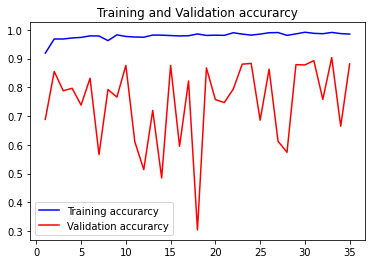

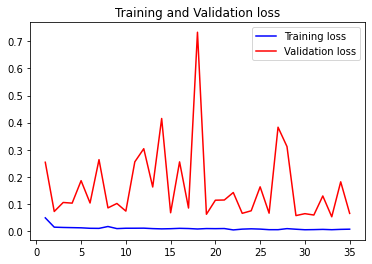

[INFO] Calculating model accuracy
36/36 [==============================] - 1s 40ms/step - loss: 0.0647 - accuracy: 0.8812
Test Accuracy: 88.12227249145508
[INFO] Saving model


In [ ]:
Res_Plot_Test_Save('VGG16_With_Imagenet_Weingts.h5')

In [ ]:
import numpy as np
import cv2
from os import listdir
import tensorflow as tf
import pickle
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

In [ ]:
EPOCHS = 35
INIT_LR = 1e-4
DECAY = 1e-6
BS = 64
default_image_size = tuple((256, 256))
resized_image_size = tuple((128,128))
image_size = 0
directory_root = '/content/drive/MyDrive/PlantVillage'

In [ ]:
# Function to convert image to array.
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, resized_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for plant_folder in root_dir:
        print(f"[INFO] Processing {plant_folder} ....")
        plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}")
        
        for image_var in plant_disease_image_list[:400]:
            image_directory = f"{directory_root}/{plant_folder}/{image_var}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_folder)


    print("[INFO] Image loading completed!")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato_healthy ....
[INFO] Processing Potato___healthy ....
[INFO] Processing Tomato_Septoria_leaf_spot ....
[INFO] Processing Tomato_Leaf_Mold ....
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ....
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ....
[INFO] Processing Potato___Late_blight ....
[INFO] Processing Potato___Early_blight ....
[INFO] Processing Tomato_Early_blight ....
[INFO] Processing Tomato__Target_Spot ....
[INFO] Processing Pepper__bell___Bacterial_spot ....
[INFO] Processing Pepper__bell___healthy ....
[INFO] Processing Tomato_Late_blight ....
[INFO] Processing Tomato_Bacterial_spot ....
[INFO] Processing Tomato__Tomato_mosaic_virus ....
[INFO] Image loading completed!


In [ ]:
image_size = len(image_list)

In [ ]:
# Assign the classes to images.
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)

In [ ]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [ ]:
# Convert the array to a NumPy list and normalise it.
np_image_list = np.array(image_list, dtype = np.float16) / 255.0

In [ ]:
print("[INFO] Spliting data into train set and test set ...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size = 0.2, random_state = 42) 
print("[INFO] Spliting complete!")

[INFO] Spliting data into train set and test set ...
[INFO] Spliting complete!


In [ ]:
aug = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2, 
    zoom_range = 0.2,
    horizontal_flip = True, 
    fill_mode = "nearest")

In [ ]:
# Initialize the model.
model = Sequential()
          
# 1st Convolutional Layer
model.add(Conv2D(filters = 96, input_shape = (128,128,3), kernel_size = (11,11), strides = (4,4), padding = 'valid'))
model.add(Activation('relu'))
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())
# Pooling Layer
model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters = 256, kernel_size = (5,5), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
# Pooling Layer
model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters = 384, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
# Dropout
model.add(Dropout(0.5))

# 4th Convolutional Layer
model.add(Conv2D(filters = 384, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
# Dropout
model.add(Dropout(0.5))

# 5th Convolutional Layer
model.add(Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
# Pooling Layer
model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'valid'))
# Dropout
model.add(Dropout(0.5))

# Passing it to a dense layer
model.add(Flatten())

# 1st Dense Layer
model.add(Dense(4096, input_shape = (224*224*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.25))
# Batch Normalisation
model.add(BatchNormalization())

# 2nd Dense Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.5))
# Batch Normalisation
model.add(BatchNormalization())

# 3rd Dense Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.5))
# Batch Normalisation
model.add(BatchNormalization())

# Output Layer
model.add(Dense(n_classes))
model.add(Activation('softmax'))

# Get the model summary.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_99 (Conv2D)           (None, 30, 30, 96)        34944     
_________________________________________________________________
activation_101 (Activation)  (None, 30, 30, 96)        0         
_________________________________________________________________
batch_normalization_100 (Bat (None, 30, 30, 96)        384       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 96)        0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 14, 14, 256)       614656    
_________________________________________________________________
activation_102 (Activation)  (None, 14, 14, 256)       0         
_________________________________________________________________
batch_normalization_101 (Bat (None, 14, 14, 256)      

In [ ]:
# Compile 
opt = tf.keras.optimizers.Adam(lr = INIT_LR, decay = DECAY)
model.compile(loss="binary_crossentropy", optimizer = opt,metrics = ["accuracy"])
print("[INFO] Training network...")

# Train
checkpoint = ModelCheckpoint("AlexNet.h5", monitor = 'accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'auto', save_freq='epoch')

history = model.fit(
    aug.flow(x_train, y_train, batch_size = BS, shuffle = False),
    validation_data = (x_test, y_test),
    steps_per_epoch = len(x_train) // BS,
    callbacks = [checkpoint],
    epochs = EPOCHS,
    verbose=1 )

[INFO] Training network...
Epoch 1/35
71/71 [==============================] - 20s 255ms/step - loss: 0.8825 - accuracy: 0.0743 - val_loss: 0.6696 - val_accuracy: 0.0716

Epoch 00001: accuracy improved from -inf to 0.08658, saving model to AlexNet.h5
Epoch 2/35
71/71 [==============================] - 17s 242ms/step - loss: 0.8227 - accuracy: 0.0996 - val_loss: 0.7031 - val_accuracy: 0.0786

Epoch 00002: accuracy improved from 0.08658 to 0.10452, saving model to AlexNet.h5
Epoch 3/35
71/71 [==============================] - 17s 239ms/step - loss: 0.7761 - accuracy: 0.1206 - val_loss: 0.7407 - val_accuracy: 0.0786

Epoch 00003: accuracy improved from 0.10452 to 0.12733, saving model to AlexNet.h5
Epoch 4/35
71/71 [==============================] - 17s 242ms/step - loss: 0.7215 - accuracy: 0.1317 - val_loss: 0.6553 - val_accuracy: 0.0786

Epoch 00004: accuracy improved from 0.12733 to 0.13065, saving model to AlexNet.h5
Epoch 5/35
71/71 [==============================] - 17s 240ms/step -

[INFO] Plotting model accuracy and Loss


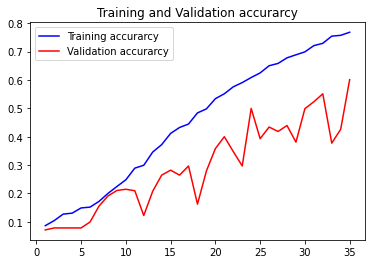

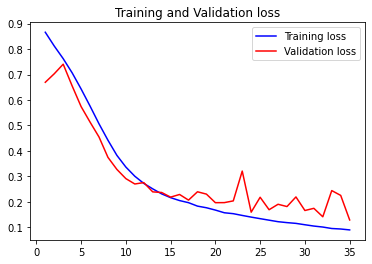

[INFO] Calculating model accuracy
36/36 [==============================] - 1s 18ms/step - loss: 0.1288 - accuracy: 0.6009
Test Accuracy: 60.08733510971069
[INFO] Saving model


In [ ]:
Res_Plot_Test_Save('AlexNet.h5')